In [2]:
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Class weight calculation
from sklearn.utils.class_weight import compute_class_weight
# Keras library
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
# Different CNN Model
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121
# To chain two different data augmented images for training
from itertools import chain
#  Distributed Computing
import tensorflow as tf

In [3]:
BATCH_SIZE = 48
image_height = 224
image_width = 224

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
TRAIN_DIR = "/content/drive/MyDrive/dataset/Leaf Disease Dataset/train"
VAL_DIR = "/content/drive/MyDrive/dataset/Leaf Disease Dataset/validation"


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_height = 224
image_width = 224
BATCH_SIZE = 32

# Data augmentation for training
data_generator_1 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# No augmentation for validation, just rescale
data_generator_3 = ImageDataGenerator(rescale=1./255)

train_generator1 = data_generator_1.flow_from_directory(
    directory=TRAIN_DIR,
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

print('✅ Data Augmentation 1 was used to generate train data set\n')

test_generator = data_generator_3.flow_from_directory(
    directory=VAL_DIR,
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)


Found 2826 images belonging to 9 classes.
✅ Data Augmentation 1 was used to generate train data set

Found 180 images belonging to 9 classes.


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load base model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze layers

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_generator1.num_classes, activation='softmax')  # Output layer
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset/Leaf Disease Dataset/train',
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset/Leaf Disease Dataset/validation',
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical'
)


Found 2826 images belonging to 9 classes.
Found 180 images belonging to 9 classes.


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the pretrained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.fit(train_generator, validation_data=test_generator, epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 669s 4s/step - accuracy: 0.5649 - loss: 1.2725 - val_accuracy: 0.9000 - val_loss: 0.2952
Epoch 2/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 33s 189ms/step - accuracy: 0.8699 - loss: 0.3855 - val_accuracy: 0.9611 - val_loss: 0.1433
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.8967 - loss: 0.2800 - val_accuracy: 1.0000 - val_loss: 0.0788
Epoch 4/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.9231 - loss: 0.2217 - val_accuracy: 0.9833 - val_loss: 0.0867
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 33s 189ms/step - accuracy: 0.9327 - loss: 0.1824 - val_accuracy: 0.9722 - val_loss: 0.0965


In [17]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_leaf_disease(image_path):
    img = image.load_img(image_path, target_size=(128, 128))  # ✅ make sure size is 128x128
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # (1, 128, 128, 3)
    img_array = img_array / 255.0  # normalize if your model was trained this way

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    print(f"Predicted class: {predicted_class}")


SyntaxError: invalid syntax (<ipython-input-15-1e6d394690ab>, line 1)

In [18]:
predict_leaf_disease("/content/drive/MyDrive/test_leaf.jpg")



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: 2


In [20]:
# Save model
model.save("rice_leaf_disease_model.h5")

# Later, load it with:
from tensorflow.keras.models import load_model
model = load_model("rice_leaf_disease_model.h5")


In [43]:
model.save("rice_leaf_disease1_model.h5")


In [44]:
from google.colab import files
files.download("/content/rice_leaf_disease1_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
from google.colab import files
uploaded = files.upload()


Saving test_leaf.jpg to test_leaf.jpg


In [29]:
def predict_leaf_disease(image_path):
    # Load and preprocess image
    img = load_img(image_path, target_size=(128, 128))  # match training size
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction[0])

    # Map class index to label
    class_labels = train_generator1.class_indices
    label_map = dict((v, k) for k, v in class_labels.items())
    predicted_label = label_map[class_index]

    # Parse disease and severity
    if " - " in predicted_label:
        disease, severity = predicted_label.split(" - ")
    elif predicted_label.lower().startswith(("mild", "moderate", "severe")):
        severity, disease = predicted_label.split(" ", 1)
    else:
        disease = predicted_label
        severity = "Unknown"

    print(f"🦠 Disease: {disease}")
    print(f"📉 Severity: {severity}")


In [30]:
predict_leaf_disease("test_leaf.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
🦠 Disease: Blast
📉 Severity: Mild


In [41]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_leaf_disease(image_path):
    # Load and preprocess image
    img = load_img(image_path, target_size=(128, 128))  # match training size
    img_array = img_to_array(img) / 255.0
    img_array_exp = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array_exp)
    class_index = np.argmax(prediction[0])

    # Map class index to label
    class_labels = train_generator1.class_indices
    label_map = dict((v, k) for k, v in class_labels.items())
    predicted_label = label_map[class_index]
    confidence = prediction[0][class_index]

    # Parse disease and severity
    if " - " in predicted_label:
        disease, severity = predicted_label.split(" - ")
    elif predicted_label.lower().startswith(("mild", "moderate", "severe")):
        severity, disease = predicted_label.split(" ", 1)
    else:
        disease = predicted_label
        severity = "Unknown"

    # Display result on image
    img_display = Image.open(image_path).convert("RGB").resize((256, 256))
    draw = ImageDraw.Draw(img_display)
    font = ImageFont.load_default()
    text = f"Disease: {disease} | Severity: {severity} | Confidence: {confidence:.2f}"
    draw.text((10, 10), text, fill="black", font=font)

    plt.figure(figsize=(5,5))
    plt.imshow(img_display)
    plt.axis('off')
    plt.title("Prediction Result")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


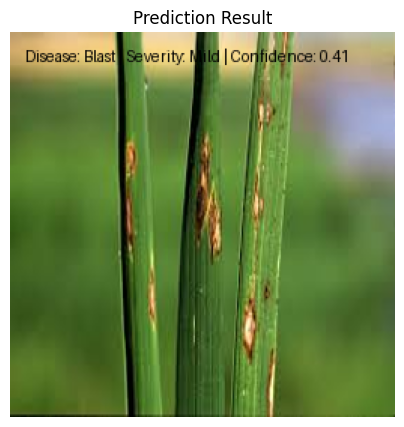

In [42]:
predict_leaf_disease("test_leaf.jpg")

In [45]:
from google.colab import files
uploaded = files.upload()


Saving TUNGRO5_171.JPG to TUNGRO5_171.JPG


In [46]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_local_image(filename):
    # Preprocess for model (resize to match training)
    img = load_img(filename, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array_exp = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array_exp)
    class_index = np.argmax(prediction[0])

    # Get label mapping
    class_labels = train_generator1.class_indices
    label_map = dict((v, k) for k, v in class_labels.items())
    predicted_label = label_map[class_index]
    confidence = prediction[0][class_index]

    # Parse disease and severity
    if " - " in predicted_label:
        disease, severity = predicted_label.split(" - ")
    elif predicted_label.lower().startswith(("mild", "moderate", "severe")):
        severity, disease = predicted_label.split(" ", 1)
    else:
        disease = predicted_label
        severity = "Unknown"

    # Display result on image
    img_display = Image.open(filename).convert("RGB").resize((256, 256))
    draw = ImageDraw.Draw(img_display)
    font = ImageFont.load_default()
    text = f"{disease} ({severity}) - {confidence:.2f}"
    draw.text((10, 10), text, fill="white", font=font)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_display)
    plt.axis('off')
    plt.title("Prediction Result")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


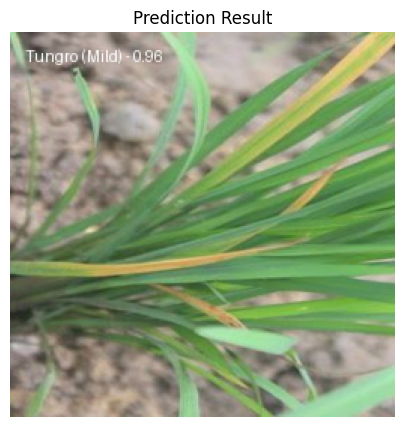

In [49]:
predict_local_image("TUNGRO5_171.JPG")  # Correct the file extension to match the actual file name

